In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import os
import cv2
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(128*128*3, 512)
        self.linear2 = nn.Linear(512, latent_dims)
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 128*128*3)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 128, 128))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).mean()
            loss.backward()
            opt.step()
        
    return autoencoder

In [7]:
class CatsGeeseDataset(Dataset):
    def __init__(self, path,transform):
        self.path = path
        self.transform = transform
        
        self.file_names_lst = [el for el in os.listdir(path) if ('cat' in el) or ('goose' in el)]

    def __len__(self):
        return len(self.file_names_lst)

    def __getitem__(self, idx):
        img_name = self.file_names_lst[idx]
        img = self.transform(cv2.imread(os.path.join(self.path,img_name))/255).float()
        tar = 1 if img_name.split('_')[0] == 'goose' else 0
                         
        return img, tar

In [8]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)

data = DataLoader(
        CatsGeeseDataset('pics/dataset/', 
               transform=torchvision.transforms.ToTensor()),
        batch_size=128,
        shuffle=True)

autoencoder = train(autoencoder, data, epochs=100)

goose


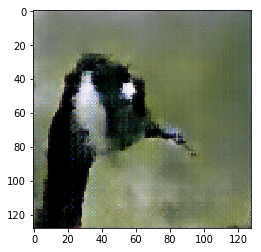

In [13]:
imgs, labels = next(iter(data))
img = imgs[0].transpose(0,2).transpose(0,1).numpy()[:,:,::-1]
lbl = labels[0]

print('goose' if lbl.item() else 'cat')
plt.imshow(img);

goose


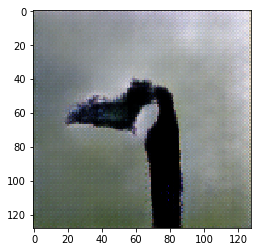

In [15]:
imgs, labels = next(iter(data))
img = imgs[0].transpose(0,2).transpose(0,1).numpy()[:,:,::-1]
lbl = labels[0]

print('goose' if lbl.item() else 'cat')
plt.imshow(img);

cat


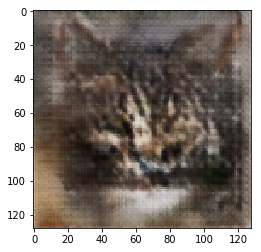

In [16]:
imgs, labels = next(iter(data))
img = imgs[0].transpose(0,2).transpose(0,1).numpy()[:,:,::-1]
lbl = labels[0]

print('goose' if lbl.item() else 'cat')
plt.imshow(img);

cat


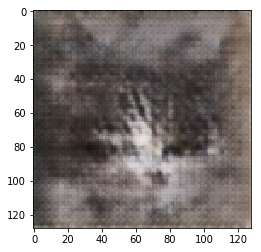

In [17]:
imgs, labels = next(iter(data))
img = imgs[0].transpose(0,2).transpose(0,1).numpy()[:,:,::-1]
lbl = labels[0]

print('goose' if lbl.item() else 'cat')
plt.imshow(img);

In [9]:
def plot_latent(autoencoder, data):
    fig, ax = plt.subplots(figsize=(10,10))
    for x, y in data:
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        ax.scatter(z[:, 0], z[:, 1], c=y)

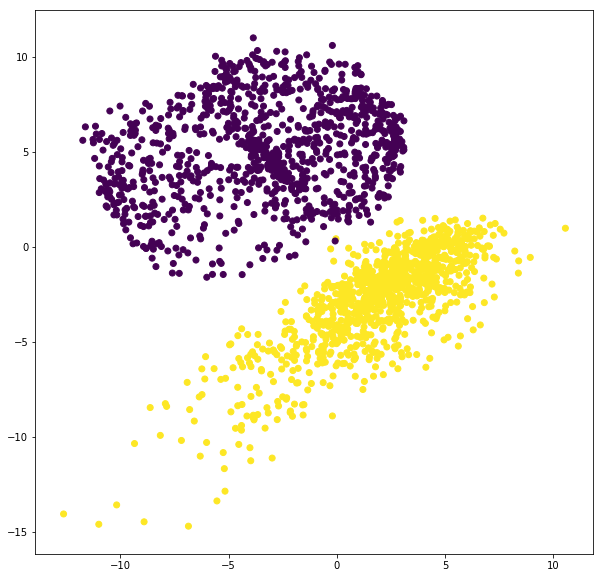

In [10]:
plot_latent(autoencoder, data)